In [1]:
# -*- coding: utf-8 -*-
"""

@author: tmoorman

IST 652 Final Projest
"""

'\n\n@author: tmoorman\n\nIST 652 Final Projest\n'

In [2]:
#import relevant packages and set the working directory
import os
os.chdir("C:/Users/tmoorman/OneDrive - BeyondTrust Software Inc/Documents/Not Work Related/school/Spring 2019/IST 652/FinalProject")
import numpy as np
import pandas as p
import sklearn

In [3]:
#read in data sets
fights = p.read_excel('fights.xlsx')
fighters = p.read_excel('fighters.xlsx')
fightmets = p.read_excel('fightmetric.xlsx')

In [4]:
#clean data sets to relevant dates and choose relevant columns for analysis
fights = fights[fights.event_date >= '2003-1-1']
fightscol = ['f1fid', 'f2fid', 'f1result', 'f2result', 'ref', 'event_date']

fights = fights[fightscol]

fighterscol = ['fid', 'birth_date', 'height', 'weight', 'association', 'class', 'country' ]

fighters = fighters[fighterscol]

fightmetscol = ['fid', 'Wins', 'Losses', 'Reach', 'Stance', 'SLpM', 'Str. Acc', 'SApM', 'Str. Def', 'TD Avg', 'TD Acc', 'TD Def', 'Sub. Avg']

fightmets = fightmets[fightmetscol]

fightmets = fightmets.dropna(subset=['fid'])


In [5]:
#Merge fighter datasets together
fNEW = fighters.merge(fightmets, on=['fid'])

In [6]:
#seperate wins and losses
fightlosscol = ['f2fid', 'f2result','ref', 'event_date']
fightwincol = ['f1fid', 'f1result','ref', 'event_date']

win = fights[fightwincol]
loss = fights[fightlosscol]

In [7]:
#rename columns in win and loss datasets
win = win.rename(index=str, columns = {'f1fid' : 'fid', 'f1result' : 'result'})
loss = loss.rename(index=str, columns = {'f2fid' : 'fid', 'f2result' : 'result'})

In [8]:
#append win and loss datasets to create new fight dataframe with wins and losses to ultimately create target variable
totalfights = win.append(loss, ignore_index = True)

totalfights['y'] = np.where(totalfights['result']== 'win', 1, 0)

In [9]:
#merge all fight data with fighter data to get data for every fighter in every fight
finalset = totalfights.merge(fNEW, on=['fid'])

#getting rid of columns that are unwanted, creating binaries for a factored feature
finalset = finalset.drop('fid', axis=1)
finalset = finalset.drop('result', axis=1)
finalset = finalset.drop('association', axis=1)
finalset = finalset.drop('class', axis=1)
finalset['stancebin'] = np.where(finalset['Stance']== 'Orthodox', 1, 0)
finalset = finalset.drop('Stance', axis=1)

In [10]:
#Creating 'age' variable for the age of fighter at time of fight
finalset['age'] = finalset['event_date'] - finalset['birth_date']
finalset['age'] = finalset['age'].dt.days
finalset = finalset.drop('event_date', axis=1)
finalset = finalset.drop('birth_date', axis=1)

#dropping any remaining rows with NANs
finalset = finalset.dropna()

In [11]:
##Encoding country and ref fields
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
label_encoder = LabelEncoder()
country_encoded = label_encoder.fit_transform(finalset['country'])
ref_encoded = label_encoder.fit_transform(finalset['ref'])
print(country_encoded)

finalset['countrycode'] = country_encoded
finalset['refcode'] = ref_encoded

finalset = finalset.drop('country', axis=1)
finalset = finalset.drop('ref', axis=1)

[52 52 52 ... 52 52  7]


In [12]:
#making certain datatypes were correct
finalset.dtypes

y                int32
height         float64
weight         float64
Wins             int64
Losses           int64
Reach          float64
SLpM           float64
Str. Acc       float64
SApM           float64
Str. Def       float64
TD Avg         float64
TD Acc         float64
TD Def         float64
Sub. Avg       float64
stancebin        int32
age            float64
countrycode      int64
refcode          int64
dtype: object

In [40]:
#Creating test and train sets, importing relevant packages, and training and testing model
x = finalset.drop('y', axis=1)
y = finalset['y']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.03, random_state=0)  

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
regressor = RandomForestClassifier(n_estimators=3000, random_state=0)
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test) 

print("Confusion Matrix: ", confusion_matrix(y_test,y_pred))
print(" ")
print("Metrics: ", classification_report(y_test,y_pred))  
print("Model Accuracy: ", accuracy_score(y_test, y_pred))

Confusion Matrix:  [[42 30]
 [32 58]]
 
Metrics:               precision    recall  f1-score   support

          0       0.57      0.58      0.58        72
          1       0.66      0.64      0.65        90

avg / total       0.62      0.62      0.62       162

Model Accuracy:  0.6172839506172839


In [14]:
#creating a list of feature importance measures
feature_imp = p.Series(regressor.feature_importances_,index=X_train.columns).sort_values(ascending=False)


Text(0.5,1,'Important Features')

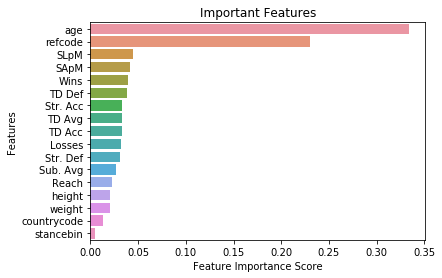

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a bar plot of the classifier feature importances
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features")


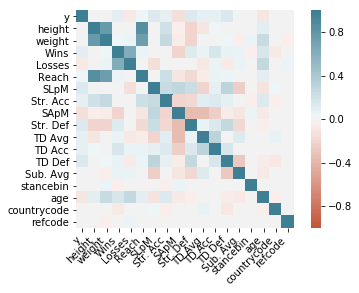

In [17]:
#Making correlation matrix of features
corr = finalset.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Text(0.5,1,'Win/Loss by Age')

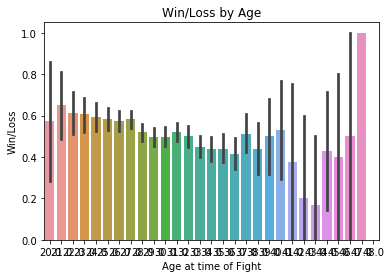

In [19]:
#Creating plots of most important features by wins and losses
#Ages by winning
sns.barplot(x=round((finalset['age']/365)), y=finalset['y'])
plt.xlabel('Age at time of Fight')
plt.ylabel('Win/Loss')
plt.title("Win/Loss by Age")

Text(0.5,1,'Win/Loss by Stance')

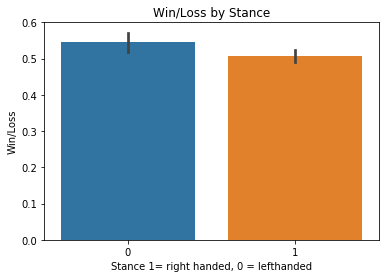

In [21]:
#Stance
sns.barplot(x=finalset['stancebin'], y=finalset['y'])
plt.xlabel('Stance 1= right handed, 0 = lefthanded')
plt.ylabel('Win/Loss')
plt.title("Win/Loss by Stance")

Text(0.5,1,'Win/Loss by Record')

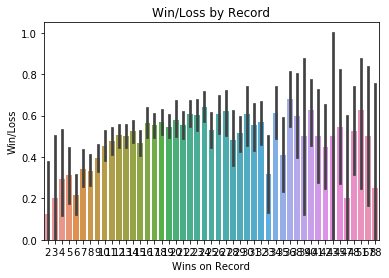

In [22]:
#Wins
sns.barplot(x=finalset['Wins'], y=finalset['y'])
plt.xlabel('Wins on Record')
plt.ylabel('Win/Loss')
plt.title("Win/Loss by Record")

Text(0.5,1,'Age Histogram')

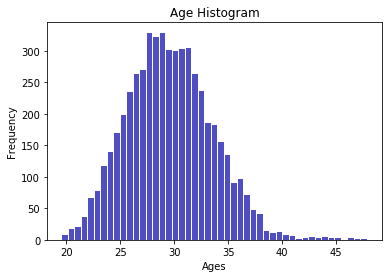

In [23]:
#Histogram of Ages
n, bins, patches = plt.hist(x=(finalset['age']/365), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('Ages')
plt.ylabel('Frequency')
plt.title('Age Histogram')

In [30]:
#Creating Aggregate Tables

bindf = finalset[['y']]
bindf['binheight'] = p.cut(finalset['height'], 5)
bindf['binweight'] = p.cut(finalset['weight'], 5)
bindf['binwins'] = p.cut(finalset['Wins'], 5)
bindf['binreach'] = p.cut(finalset['Reach'], 5)
bindf['binstance'] = finalset['stancebin']
bindf['binage'] = p.cut(round(finalset['age']/365), 5)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [37]:
#Percent of fights with each metric binned

In [31]:
bindf.groupby(['binage'])[['y']].count()/5391

,y
binage,
"(19.972, 25.6]",0.148395
"(25.6, 31.2]",0.545724
"(31.2, 36.8]",0.262474
"(36.8, 42.4]",0.039139
"(42.4, 48.0]",0.004266


In [32]:
bindf.groupby(['binweight'])[['y']].count()/5391

,y
binweight,
"(104.793, 146.4]",0.259136
"(146.4, 187.8]",0.554257
"(187.8, 229.2]",0.113523
"(229.2, 270.6]",0.072528
"(270.6, 312.0]",0.000556


In [33]:
bindf.groupby(['binwins'])[['y']].count()/5391

,y
binwins,
"(1.914, 19.2]",0.623261
"(19.2, 36.4]",0.347802
"(36.4, 53.6]",0.027082
"(53.6, 70.8]",0.001113
"(70.8, 88.0]",0.000742


In [34]:
bindf.groupby(['binreach'])[['y']].count()/5391

,y
binreach,
"(59.976, 64.8]",0.023743
"(64.8, 69.6]",0.171211
"(69.6, 74.4]",0.509182
"(74.4, 79.2]",0.265813
"(79.2, 84.0]",0.030050


In [35]:
bindf.groupby(['binstance'])[['y']].sum()

,y
binstance,
0,719
1,2069


In [36]:
bindf.groupby(['y'])[['binstance']].count()

,binstance
y,
0,2603
1,2788
